In [1]:
# list available GPUs and set the device
import torch
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [2]:
# load data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

data_path = "../data"

training_data = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root=data_path,
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# load model and pretrained weights
from torchvision.models import resnet50
import torch

model_path = "../pretrained_weights/resnet50-11ad3fa6.pth"
model = resnet50().to(device)
model.load_state_dict(torch.load(model_path))
# model.eval()

# remove certain number of layers from the model
from src.model_utils import remove_layers

trimmed_model = remove_layers(model, 2)
# print(trimmed_model)

C:\Users\tienj\AppData\Local\Temp\ipykernel_47920\4284353995.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [4]:
# create data loaders
from torch.utils.data import DataLoader
batch_size = 512
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
# some parameters
target_class = 4 # take cat as an example

In [5]:
# extract features from the model
import torch.nn.functional as F
def extract_features(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    features = []
    with torch.no_grad():
        for images, _ in data_loader:
            output = model(images.to(device))
            features.append(output)
    return torch.cat(features)

# extract features
train_features = extract_features(trimmed_model, train_loader)
print(f"Extracted {train_features.shape[0]} training features with shape {train_features.shape[1:]}")
# test_features = extract_features(trimmed_model, test_loader)

Extracted 50000 training features with shape torch.Size([2048])


In [ ]:
# make a cluster to generate predictions and to find out which are hard examples
from sklearn.cluster import KMeans
import numpy as np

def generate_confidence(features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features.cpu().numpy())
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    
    # Calculate confidence as the distance to the nearest cluster center
    distances = np.linalg.norm(features.cpu().numpy()[:, np.newaxis] - cluster_centers, axis=2)
    confidence = 1 - np.min(distances, axis=1) / np.max(distances, axis=1)
    
    return cluster_centers, cluster_labels, confidence

cluster_center, train_labels, train_generate_confidence = generate_confidence(train_features, n_clusters=10)

In [30]:
# find out which cluster maps to target class
# this is the index of the cluster that maps to the target class
target_class_idxes = np.where(torch.tensor(training_data.targets) == target_class)[0] 
print(f"Target class {target_class} is in clusters: {set(target_class_idxes)}")

filtered_labels = train_labels[target_class_idxes]
print(f"Filtered labels for target class {target_class}: {filtered_labels}")

# find out which cluster is the most common for the target class
from collections import Counter 
most_common_cluster = Counter(filtered_labels).most_common(1)[0][0]
print(f"Most common cluster for target class {target_class}: {most_common_cluster}")

print(cluster_center[most_common_cluster])

Target class 4 is in clusters: {np.int64(3), np.int64(32776), np.int64(10), np.int64(32784), np.int64(32786), np.int64(20), np.int64(32789), np.int64(28), np.int64(32797), np.int64(32799), np.int64(34), np.int64(32803), np.int64(32818), np.int64(32822), np.int64(58), np.int64(66), np.int64(32842), np.int64(82), np.int64(86), np.int64(32854), np.int64(89), np.int64(98), np.int64(32867), np.int64(32882), np.int64(32890), np.int64(32892), np.int64(32893), np.int64(130), np.int64(32901), np.int64(32909), np.int64(145), np.int64(149), np.int64(153), np.int64(158), np.int64(32928), np.int64(32929), np.int64(162), np.int64(32930), np.int64(175), np.int64(32947), np.int64(180), np.int64(32960), np.int64(32961), np.int64(32969), np.int64(32989), np.int64(32997), np.int64(33002), np.int64(33004), np.int64(33013), np.int64(247), np.int64(33015), np.int64(33016), np.int64(33020), np.int64(254), np.int64(33027), np.int64(263), np.int64(268), np.int64(33037), np.int64(33038), np.int64(272), np.int64

In [40]:
wrong_indexes = np.where(filtered_labels != most_common_cluster)[0]
print(f"Indexes of wrong predictions: {wrong_indexes}")
print(f"number of wrong predictions: {len(wrong_indexes)}")
print(f"number of correct predictions: {len(np.where(filtered_labels == most_common_cluster)[0])}")
# miss_classified = train_features[wrong_indexes]

Indexes of wrong predictions: [   2    4    6 ... 4996 4997 4999]
number of wrong predictions: 2872
number of correct predictions: 2128


Text(0, 0.5, 'Frequency')

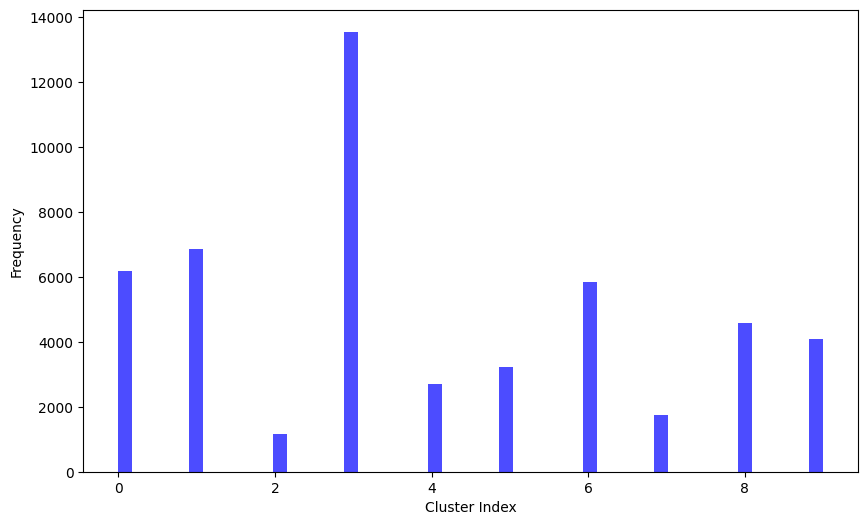

In [42]:
# draw a distribution of clustered features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(train_labels, bins=50, alpha=0.7, color='blue', label='Label Distribution')
plt.xlabel('Cluster Index')
plt.ylabel('Frequency')

In [ ]:
miss_classified = train_features[train_labels != most_common_cluster]
print(train_features[train_labels != most_common_cluster])
print(f'Miss classified features: {np.where(miss_classified)==True}')

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2463, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.8116, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7764, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
Miss classified features: False


Target class 4 is in clusters: {np.int64(3), np.int64(32776), np.int64(10), np.int64(32784), np.int64(32786), np.int64(20), np.int64(32789), np.int64(28), np.int64(32797), np.int64(32799), np.int64(34), np.int64(32803), np.int64(32818), np.int64(32822), np.int64(58), np.int64(66), np.int64(32842), np.int64(82), np.int64(86), np.int64(32854), np.int64(89), np.int64(98), np.int64(32867), np.int64(32882), np.int64(32890), np.int64(32892), np.int64(32893), np.int64(130), np.int64(32901), np.int64(32909), np.int64(145), np.int64(149), np.int64(153), np.int64(158), np.int64(32928), np.int64(32929), np.int64(162), np.int64(32930), np.int64(175), np.int64(32947), np.int64(180), np.int64(32960), np.int64(32961), np.int64(32969), np.int64(32989), np.int64(32997), np.int64(33002), np.int64(33004), np.int64(33013), np.int64(247), np.int64(33015), np.int64(33016), np.int64(33020), np.int64(254), np.int64(33027), np.int64(263), np.int64(268), np.int64(33037), np.int64(33038), np.int64(272), np.int64

In [26]:
# show the kmeans score for each elements in the target class
import matplotlib.pyplot as plt
def plot_kmeans_scores(labels, cluster_centers, scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(labels)), scores, c=labels, cmap='viridis', marker='o', s=10)
    plt.colorbar(label='Cluster Label')
    plt.xlabel('Sample Index')
    plt.ylabel('KMeans Score')
    plt.title('KMeans Scores for Target Class Samples')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
    plt.show()

plot_kmeans_scores(filtered_labels, cluster_center, train_preds[target_class_idxes])

TypeError: 'float' object is not subscriptable